<a href="https://colab.research.google.com/github/RGivisiez/TensorFlow-Templates/blob/main/Tensorflow_Prepocessing_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Dataset

In [1]:
import numpy as np
import pandas as pd
from keras import layers
import tensorflow as tf

In [2]:
int_numbers = np.arange(1, 101)
chars = [chr(value) for value in int_numbers]
float_numbers = np.linspace(0, 50, 100)
ordinal = np.repeat([0, 3, 5, 7, 9], 20)
guassian = np.random.normal(15, 2.5, 100)

In [3]:
df = pd.DataFrame({'int':int_numbers, 'char':chars, 'float':float_numbers,
                   'ord':ordinal, 'randG':guassian})
df.head()

,int,char,float,ord,randG
0,1,,0.000000,0,17.337220
1,2,,0.505051,0,17.301942
2,3,,1.010101,0,15.053279
3,4,,1.515152,0,16.485809
4,5,,2.020202,0,14.763017


In [4]:
num_cols = df.select_dtypes('number').columns.to_list()
obj_cols = df.select_dtypes('object').columns.to_list()

### Auxiliary Functions

In [5]:
def get_normalization_layer(name, dataset):

  normalizer = layers.Normalization()

  feature_ds = dataset[name]

  normalizer.adapt(feature_ds)

  return normalizer

def get_discretization_layer(name, dataset, num_bins):

  discretizer = layers.Discretization(num_bins=num_bins, epsilon=1e-10)
      
  feature_ds = dataset[name]

  discretizer.adapt(feature_ds)

  return discretizer

def get_category_encoding_layer(name, dataset, dtype, output_mode='int', max_tokens=None):
  
  if dtype == 'string':
    #Note that, for strings, index 0 is reserved for out-of-vocabulary values
    #(values that were not seen during adapt()).
    categories = layers.StringLookup(max_tokens=max_tokens, output_mode=output_mode)
  else:
    #Note that, for integers, index 0 is reserved for missing values 
    #(which you should specify as the value 0), and index 1 is reserved for
    # out-of-vocabulary values (values that were not seen during adapt())
    categories = layers.IntegerLookup(max_tokens=max_tokens, output_mode=output_mode)
    
  feature_ds = dataset[name]

  categories.adapt(feature_ds)

  return categories

### Create Preprossing Layers 

In [17]:
norm_cols = [num_cols[1], num_cols[3]]
disc_cols = [num_cols[0]]
onehot_cols = [num_cols[2]]
cat_cols = [obj_cols[0]]
print('Normalization: {}\nDiscretization: {}\nOneHot: {}\nCategorical: {}'.format(norm_cols, disc_cols, onehot_cols, cat_cols))

Normalization: ['float', 'randG']
Discretization: ['int']
OneHot: ['ord']
Categorical: ['char']


In [18]:
cols_order = norm_cols + disc_cols + onehot_cols + cat_cols

In [92]:
#Stack the preprocessing layers and the input layers.
input_layers = [] # Enters in model.fit
preprocess_layers = [] # Enter in Sequential()

#Normalization loop
for name in norm_cols:
  
  layer = get_normalization_layer(name, df)

  input_layer = tf.keras.Input(shape=(1,), name=name)
  preprocess_layer = layer(input_layer)

  input_layers.append(input_layer)
  preprocess_layers.append(preprocess_layer)

#Discretization loop
for name in disc_cols:
  
  layer = get_discretization_layer(name, df, num_bins=4)

  input_layer = tf.keras.Input(shape=(1,), name=name)
  preprocess_layer = tf.cast(layer(input_layer), dtype=tf.float32)

  input_layers.append(input_layer)
  preprocess_layers.append(preprocess_layer)

#One-Hot Enconding loop
for name in onehot_cols:
  
  layer = get_category_encoding_layer(name, df, dtype='float32',
                                      output_mode='one_hot')

  input_layer = tf.keras.Input(shape=(1,), name=name)
  preprocess_layer = layer(input_layer)

  input_layers.append(input_layer)
  preprocess_layers.append(preprocess_layer)

#Categorical loop
for name in cat_cols:
  
  layer = get_category_encoding_layer(name, df, 'string', max_tokens=None)

  input_layer = tf.keras.Input(shape=(1,), name=name, dtype='string')
  preprocess_layer = tf.cast(layer(input_layer), dtype=tf.float32)

  input_layers.append(input_layer)
  preprocess_layers.append(preprocess_layer)

del layer
del input_layer

float
randG
int
ord
char


In [93]:
input_layers, preprocess_layers

([<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'float')>,
  <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'randG')>,
  <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'int')>,
  <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'ord')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'char')>],
 [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_12')>,
  <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_13')>,
  <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_12')>,
  <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'integer_lookup_6')>,
  <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_13')>])

### Create Model

In [94]:
inputs = tf.keras.layers.concatenate(preprocess_layers)
output = layers.Dense(1, activation='linear', name='first_dense')(inputs)

model = tf.keras.Model(input_layers, output)

In [95]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 int (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 char (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 float (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 randG (InputLayer)             [(None, 1)]          0           []                               
                                                                                            

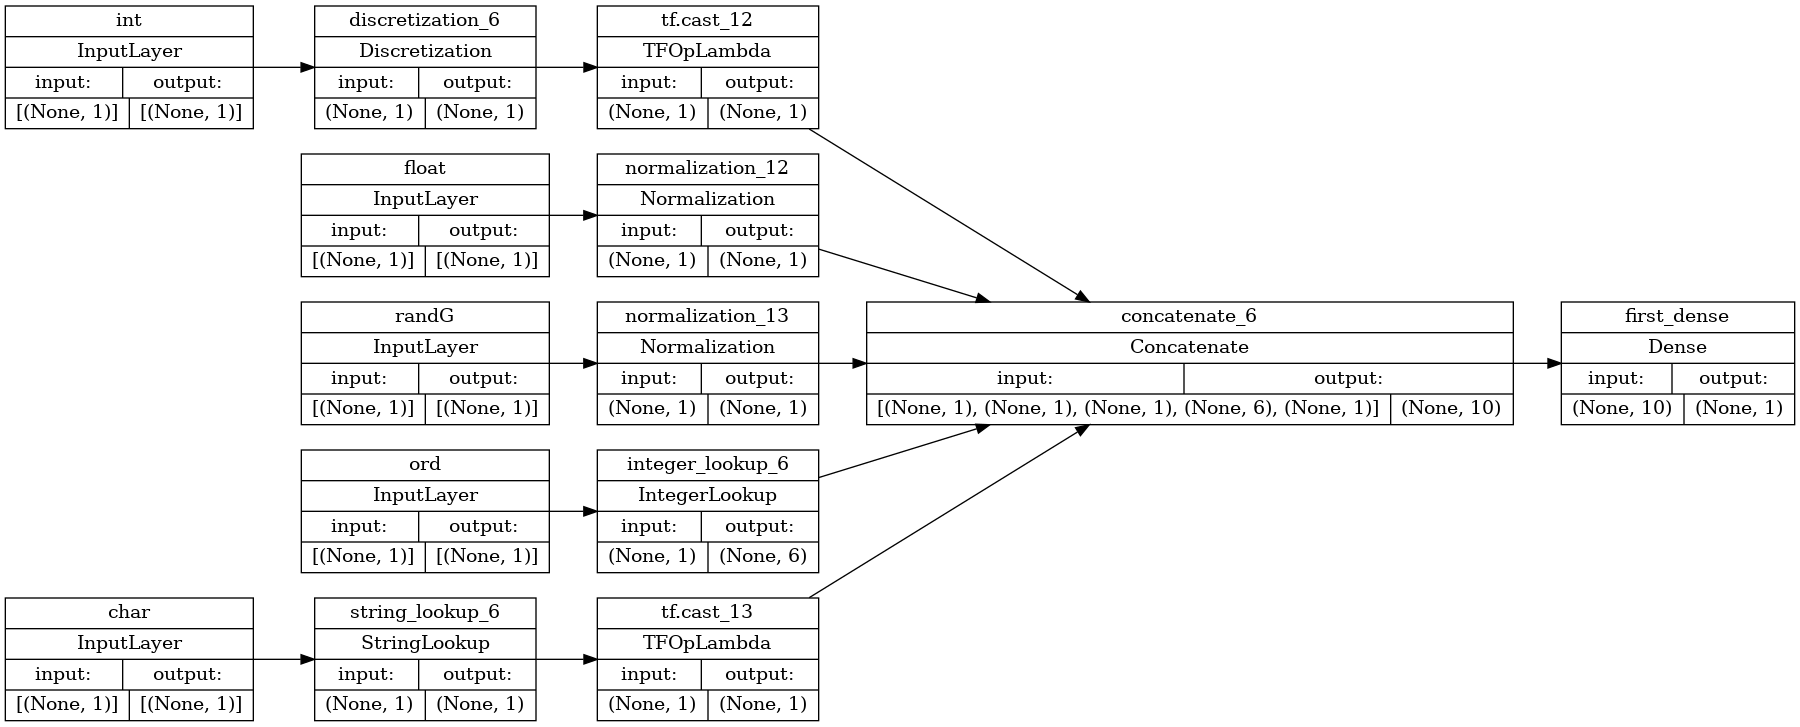

In [97]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

###Compile

In [98]:
model.compile(optimizer='adam',
              loss='MSE',
              metrics=["MAE"],
              )

###Train

In [103]:
train = [df[name].values for name in cols_order]

In [ ]:
model.fit(train, np.zeros(df.shape[0]), epochs=400,)

### Other types of layers

If you have a categorical feature that can take many different values (on the order of 10e3 or higher), where each value only appears a few times in the data, it becomes impractical and ineffective to index and one-hot encode the feature values. Instead, it can be a good idea to apply the "hashing trick": hash the values to a vector of fixed size. This keeps the size of the feature space manageable, and removes the need for explicit indexing.

In [ ]:
# Use the Hashing layer to hash the values to the range [0, 64]
hasher = layers.Hashing(num_bins=64, salt=1337)